In [44]:
import pandas as pd

from util.sql_switch import get_query_native

count_query = "select count(ds.title), ds.title, ds.created_at \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
group by \
    ds.title, ds.created_at \
order by count(ds.title) desc"

df_term_counts = get_query_native(count_query)
# print(df_term_counts.head(8))


# squashing similar titles
import functools as ft

list_of_similar_terms = [["Thema", "bleiben"], ["calm", "down"], ["constructive", "criticism"], ["explain"],
                         ["stay", "topic"], ["whataboutism"], ["valid", "point"], ["Perspektive"], ["agree"],
                         ["summary"], ["erläutern", "elaborate"]]


def title_group_mapper(text):
    group_title = text
    for term_group in list_of_similar_terms:
        for term in term_group:
            if term in text and group_title == text:
                group_title = ft.reduce(lambda x, y: x + "_" + y, term_group)
    return group_title


grouped_titles = df_term_counts["title"].map(title_group_mapper)
df_term_counts["grouped_titles"] = grouped_titles
df_term_counts.drop(["title", "created_at"], axis=1, inplace=True)
df_term_counts = df_term_counts.groupby("grouped_titles").sum()
df_term_counts.sort_values(by=["count"], axis=0, inplace=True, ascending=False)
df_term_counts.head(200)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,count
grouped_titles,
Thema_bleiben,170
"""hear your view""",50
stay_topic,46
explain,45
"""can you elaborate""",42
valid_point,41
"""näher erläutern""",39
constructive_criticism,34
agree,30


# Summary of biggest inter-coder conflicts

- load moderation rating from database or use previous
- show a list of top 10 conflicting ratings

In [45]:
import numpy as np

intercoder_query = "select dt.text, ds.created_at, ds.title, mr.u_moderating_part, mr.u_mod_rating as rating1, mr2.u_mod_rating as rating2, mr.mod_coder_id as coder_id_1, mr2.mod_coder_id as coder_id_2 \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_moderationrating mr2 on mr2.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and mr.mod_coder_id <> mr2.mod_coder_id \
  and mr.u_mod_rating <> mr2.u_mod_rating;"

df_ic = get_query_native(intercoder_query)
df_ic.drop_duplicates("text", inplace=True)
grouped_titles = df_ic["title"].map(title_group_mapper)
df_ic["grouped_titles"] = grouped_titles
df_ic.drop("title", axis=1, inplace=True)


# print(df_ic.head(3))

def calculate_coding_distance(df):
    bigger = df.max(axis=1)
    smaller = df.min(axis=1)
    result = (bigger - smaller).abs()
    return result


df_ic["intercoder_distance"] = calculate_coding_distance(df_ic[["rating1", "rating2"]])
df_ic.sort_values(by="intercoder_distance", inplace=True, ascending=False)

df_ic.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,text,created_at,u_moderating_part,rating1,rating2,coder_id_1,coder_id_2,grouped_titles,intercoder_distance
240,@AricToler Can you explain further?,2022-11-14 14:46:06.202107+00:00,Can you explain further?,2,-2,11,1,explain,4
468,"@JakeGagain Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon\n\n#CB $CB #BTC #ETH @thecloutbase https://t.co/Ln81TctR9d",2022-11-17 10:50:52.533139+00:00,"Would love to hear your view on #CB, the project looks solid and have been catching many eyes lately, low mc, low tax of 7% and their Dapp is releasing soon #CB $CB #BTC #ETH",2,-2,11,1,"""hear your view""",4
232,"@ParmenidesvonE Guter Punkt. Es ist wirklich verblüffend, dass der Bund die mittlere Duration der Bundesschuld in der Niedrig- und Nullzinsphase (ab 2016) nicht nennenswert ausgeweitet hat https://t.co/fvqi72gSo9",2022-11-14 13:29:39.444238+00:00,Guter Punkt.,2,-2,11,1,"""guter Punkt""",4
233,"@SaftmanWiki 👆Guter Punkt!\nGenau darüber denke ich im Moment nach.\n\nIch glaube, dass selbst erarbeitetes Vermögen viel wertvoller ist und glücklicher macht als geerbtes.\n\nIch habe das Ziel meinen Kindern ein Mindset + Ausbildung zu geben um jederzeit in der Lage zu sein Vermögen aufzubauen",2022-11-14 13:29:39.444238+00:00,👆Guter Punkt! Genau darüber denke ich im Moment nach.,2,-2,11,1,"""guter Punkt""",4
234,@JustinGreenewa1 Explain further. I don't believe this is correct. Certainly other underlying agents at work. Social media is no more than a tool/ device here. What cons are exploited what pros are promoted such that a 'demise' is insinuated?,2022-11-14 14:46:06.202107+00:00,Explain further.,2,-2,11,1,explain,4
235,"@MRHDebater what?! really?! Pls explain further. As far as I can see Chinese families &amp; young people still have very high esteem &amp; respect for teachers, professors especially compared to many other western countries. What's going on Sam?🙏 thx",2022-11-14 14:46:06.202107+00:00,Pls explain further.,2,-2,11,1,explain,4
236,@FinPlanKaluAja1 Laymen are here.Explain further,2022-11-14 14:46:06.202107+00:00,Explain further,2,-2,11,1,explain,4
237,"@redthespian1 Chose option #1 - Blitzo\n\nDon't want any of the characters to die, but after some consideration, I feel his death would have the best narrative impact without reducing his character and stagnating the growth of the others. I can explain further if you want.",2022-11-14 14:46:06.202107+00:00,I can explain further if you want.,2,-2,11,1,explain,4
238,@Princemugari Explain further 😂😂,2022-11-14 14:46:06.202107+00:00,Explain further 😂😂,2,-2,11,1,explain,4
239,@OfficialTravlad @OfficialTravlad can u pls explain further cos I really don’t understand what this mean,2022-11-14 14:46:06.202107+00:00,can u pls explain further cos I really don’t understand what this mean,2,-2,11,1,explain,4


# Summary of inter-coder-reliability over time and per phrases
- load the dataset from the db
- set 2 to 1, and -2 to -1 for simplicity
- compute Krippendorf-Alpha for the ratings
- plot Krippendorf-Alpha over time globally
- plot Krippendorf-Alpha over time per title

In [46]:
import simpledorff

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and mr.u_mod_rating <> 0"

df_rel = get_query_native(inter_coder_reliability_query)
grouped_titles = df_rel["title"].map(title_group_mapper)
df_rel["grouped_titles"] = grouped_titles
df_rel.drop("title", axis=1, inplace=True)

value_mapping = {2: 1, -2: -1}
coder_mapping = {1: 1}
for i in range(2, 100):
    coder_mapping[i] = 2
df_rel.replace({"mod_coder_id": value_mapping}, inplace=True)
df_rel.replace({"mr.mod_coder_id": coder_mapping}, inplace=True)
# create new time_stamp_column that takes a time_stamp every 10 units per topic
df_rel["created_at"] = df_rel["created_at"].map(lambda x: pd.to_datetime(x))
df_rel.sort_values(by="created_at", inplace=True)
df_rel.set_index("created_at", inplace=True)


def compute_incremental_krippendorf_column(df):
    df = df.copy(deep=True)
    date2krippendorf = {}

    # debugging code
    if "valid_point" in list(df.grouped_titles):
        print("testing incremental krippendorf")

    week_labels_list = []
    for week_index, weekly_labels in df.groupby(pd.Grouper(freq="2W")):
        try:
            week_labels_list.append(weekly_labels)
            week_labels_aggro = pd.concat(week_labels_list)
            s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(week_labels_aggro, experiment_col='created_at',
                                                                      annotator_col='mod_coder_id',
                                                                      class_col='u_mod_rating')
        except ZeroDivisionError:
            s_dorf = np.NaN

        for date in weekly_labels.index:
            date2krippendorf[date] = s_dorf

    pd.options.mode.chained_assignment = None
    df["krippendorf"] = df.index.map(date2krippendorf)
    return df


# compute the krippendorf for each title_group
krippendorfed_frames = []

for title in set(df_rel.grouped_titles):
    single_title_dataset = df_rel[df_rel["grouped_titles"] == title]
    df_rel_single_with_krippendorf = compute_incremental_krippendorf_column(single_title_dataset)
    krippendorfed_frames.append(df_rel_single_with_krippendorf)

df_rel_with_krippendorf = pd.concat(krippendorfed_frames)
# printing out the codings from the last day and their incremental krippendorf (aggregated over all weeks)
df_rel_with_krippendorf.last("1D")


using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


testing incremental krippendorf


,u_mod_rating,mod_coder_id,grouped_titles,krippendorf
created_at,,,,
2022-11-15 09:13:42.645863+00:00,2,11,Thema_bleiben,0.142857
2022-11-15 09:13:42.645863+00:00,2,11,Thema_bleiben,0.142857
2022-11-15 09:13:42.645863+00:00,2,11,Thema_bleiben,0.142857
2022-11-15 09:13:42.645863+00:00,2,11,Thema_bleiben,0.142857
2022-11-15 09:13:42.645863+00:00,2,11,Thema_bleiben,0.142857
...,...,...,...,...
2022-11-24 16:20:08.563560+00:00,1,11,Thema_bleiben,0.142857
2022-11-24 16:20:08.563560+00:00,2,11,Thema_bleiben,0.142857
2022-11-24 16:20:08.563560+00:00,2,11,Thema_bleiben,0.142857


### Summary of best working Terms:
- sorted by the highest krippendorf at the current time aggregating all data
- grouped by the phrases

In [47]:
df_rel_highest_icr = df_rel_with_krippendorf.groupby("grouped_titles").last()
df_rel_highest_icr.sort_values(by="krippendorf", inplace=True, ascending=False)
df_rel_highest_icr = df_rel_highest_icr.drop(["u_mod_rating", "mod_coder_id"], axis=1)

# computed the krippendorf column
# listing the highest icr by grouped_title
df_rel_highest_icr.head(20)

,krippendorf
grouped_titles,
Thema_bleiben,1.428571e-01
stay_topic,2.220446e-16
"""curious to hear"" is:reply",0.000000e+00
"""näher erläutern""",0.000000e+00
Sichtweise,0.000000e+00
Perspektive,0.000000e+00
"""focus on issue""",0.000000e+00
"""take it personal""",0.000000e+00
"""weiter erklären""",0.000000e+00


In [48]:
#calculate overall average of krippendorf

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> ''"

df_rel_2 = get_query_native(inter_coder_reliability_query)

s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(df_rel_2, experiment_col='created_at',
                                                          annotator_col='mod_coder_id',
                                                          class_col='u_mod_rating')
s_dorf

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


-0.1031280547409581

# Computing Time Sliced Development of Krippendorf

- write procedure to slice the dataframe in time spans of a week
- calculate the krippendorf per title group and week (if possible)
- plot the changes in krippendorf over time

<AxesSubplot:xlabel='created_at'>

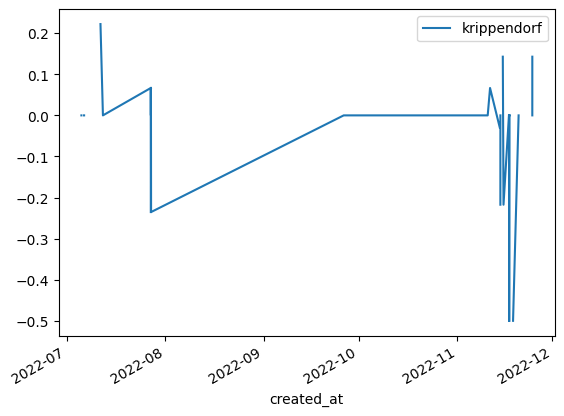

In [49]:
# krippendorf alpha for all terms
df_rel_with_krippendorf.plot.line(y="krippendorf")




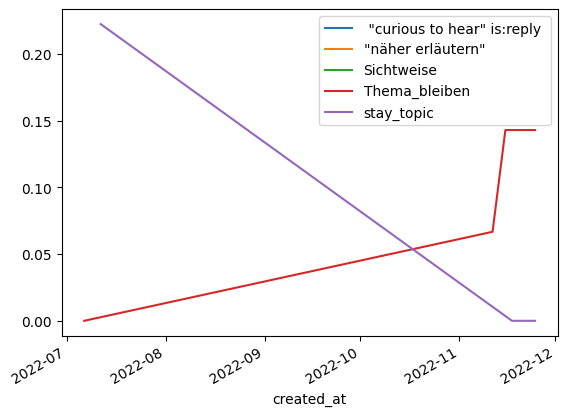

In [54]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

top_5_titles = df_rel_highest_icr.head(5)
df_rel_top_5 = df_rel_with_krippendorf[df_rel_with_krippendorf["grouped_titles"].isin(top_5_titles.index.to_list())]
#df_rel_top_5.reset_index(inplace=True)

fig, ax = plt.subplots()

for key, grp in df_rel_top_5.groupby(['grouped_titles']):
    ax = grp.plot(ax=ax, kind='line', y='krippendorf', label=key)
#ax.set_xlim([datetime.date(2022, 9, 15), datetime.date(2023, 1, 1)])
plt.legend(loc='best')
plt.show()
